In [14]:
# Vaihe 0: Kirjastojen tuonti
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Määritä polku kansioon, jossa tiedostot sijaitsevat
data_folder = "C:/Users/jonik/code/Projekti_2/project_sigma/data/HOPP"

# Tiedostojen polut
file_paths = [
    f"{data_folder}/117_HOpp-Q2_2023.xlsx",
    f"{data_folder}/117_HOpp-Q3_2023.xlsx",
    f"{data_folder}/HoPP_Q1_Kaks_Tiedonkeruulomake_kansallinen_2022.xlsx",
    f"{data_folder}/HoPP_Q3_KAKS_Tiedonkeruulomake_kansallinen_2022.xlsx",
    f"{data_folder}/HoPP_Q4_KAKS_Tiedonkeruulomake_kansallinen_2022.xlsx",
]

# Lataa ja yhdistä data
data_frames = []
for file in file_paths:
    df = pd.read_excel(file)
    data_frames.append(df)

data = pd.concat(data_frames, ignore_index=True)

# Määritä numeeriset sarakkeet (kysymykset 1-22)
numeric_columns = [col for col in data.columns if col.startswith(tuple([f"{i}." for i in range(1, 23)]))]

# Suodata vain halutut yksiköt
selected_units = ["AIKTEHOHO", "EALAPSAIK", "ENSIHOITO"]
data = data[data["YKSIKKÖKOODI\nKs. Luokitteluohje Yksikkökoodit-välilehdeltä"].isin(selected_units)]

# Korvaa 'E' arvot NaN:lla ja muunna numerot
data[numeric_columns] = data[numeric_columns].replace('E', pd.NA)
data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Ryhmittele data yksikön ja vuosineljänneksen mukaan
unit_avg = data.groupby([
    'YKSIKKÖKOODI\nKs. Luokitteluohje Yksikkökoodit-välilehdeltä',
    'KVARTAALI JA VUOSI\n(ESIM. 1_2020)'
])[numeric_columns].mean()

# Laske kansalliset keskiarvot
national_avg = data.groupby('KVARTAALI JA VUOSI\n(ESIM. 1_2020)')[numeric_columns].mean()

# Määritellään järjestysfunktio
def sort_quarters(df):
    def quarter_to_float(q):
        quarter, year = q.split('_')
        return float(year) + (float(quarter) - 1) / 4

    if isinstance(df.index, pd.MultiIndex):
        quarter_level = 1
        sorted_quarters = sorted(df.index.levels[quarter_level], key=quarter_to_float)
        return df.reindex(level=quarter_level, labels=sorted_quarters)
    else:
        return df.reindex(sorted(df.index, key=quarter_to_float))

# Järjestä keskiarvot
national_avg = sort_quarters(national_avg)
unit_avg = sort_quarters(unit_avg)


# Erotetaan 'KVARTAALI JA VUOSI\n(ESIM. 1_2020)' sarake kahdeksi uudeksi sarakkeeksi
data[['KVARTAALI', 'VUOSI']] = data['KVARTAALI JA VUOSI\n(ESIM. 1_2020)'].str.split('_', expand=True)

# Muutetaan KVARTAALI ja VUOSI numeerisiksi
data['KVARTAALI'] = data['KVARTAALI'].astype(int)
data['VUOSI'] = data['VUOSI'].astype(int)

# Luodaan 'date' sarake yhdistämällä vuosi ja kvartaali
data['date'] = pd.to_datetime(data['VUOSI'].astype(str) + 'Q' + data['KVARTAALI'].astype(str))


# Järjestetään data aikajärjestykseen
data = data.sort_values('date')

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Ladataan data ja esikäsitellään se kuten ennen
# (tässä oletetaan, että data on yhdistetty ja esikäsitelty koodisi mukaan)

# Kohteen ja piirteiden valinta
target_column = 'YKSIKKÖKOODI\nKs. Luokitteluohje Yksikkökoodit-välilehdeltä'
features = numeric_columns  # Kysymykset 1-22 toimivat piirteinä

# Pudotetaan rivit, joissa on puuttuvia arvoja piirteissä tai kohteessa
data = data.dropna(subset=features + [target_column])

# Määritellään piirteet (X) ja kohde (y)
X = data[features]
y = data[target_column]

# Jaetaan data koulutus- ja testijoukkoihin
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Luodaan RandomForest-luokittelija ja koulutetaan malli
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Ennustetaan testijoukossa ja arvioidaan malli
y_pred = rf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# (Valinnainen) Tarkista tärkeimmät piirteet
feature_importances = rf.feature_importances_
feature_importance_dict = dict(zip(features, feature_importances))
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

print("\nFeature Importances:")
for feature, importance in sorted_features:
    print(f"{feature}: {importance:.4f}")


Classification Report:
               precision    recall  f1-score   support

   AIKTEHOHO       0.00      0.00      0.00         0
   EALAPSAIK       0.00      0.00      0.00         1
   ENSIHOITO       1.00      0.75      0.86         4

    accuracy                           0.60         5
   macro avg       0.33      0.25      0.29         5
weighted avg       0.80      0.60      0.69         5

Accuracy: 0.6

Feature Importances:
14. Sain hoitajilta apua riittävän nopeasti halutessani wc:hen tai alusastian: 0.1433
6. Hoitajat kertoivat minulle uuden lääkkeen antamisen yhteydessä, miksi lääkettä annetaan: 0.1025
19. Hoitaja huolehti, että sain lievitystä kipuihin, kun siihen oli tarvetta: 0.0903
5. Hoitajat puuttuivat epäkohtaan, josta mainitsin heille: 0.0787
7. Hoitajat kertoivat minulle saamieni lääkkeiden mahdollisista sivuvaikutuksista: 0.0772
4. Hoitajat pyysivät minulta anteeksi, jos hoidossani tapahtui virhe: 0.0752
8. Hoitajat puhuivat arkaluontoisista asioista siten, et

C:\Users\jonik\AppData\Local\Temp\ipykernel_11012\1017964185.py:75: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['date'] = pd.to_datetime(data['VUOSI'].astype(str) + 'Q' + data['KVARTAALI'].astype(str))
c:\Users\jonik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jonik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_


In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold

# Määritä polku kansioon, jossa tiedostot sijaitsevat
data_folder = "C:/Users/jonik/code/Projekti_2/project_sigma/data/HOPP"

# Tiedostojen polut
file_paths = [
    f"{data_folder}/117_HOpp-Q2_2023.xlsx",
    f"{data_folder}/117_HOpp-Q3_2023.xlsx",
    f"{data_folder}/HoPP_Q1_Kaks_Tiedonkeruulomake_kansallinen_2022.xlsx",
    f"{data_folder}/HoPP_Q3_KAKS_Tiedonkeruulomake_kansallinen_2022.xlsx",
    f"{data_folder}/HoPP_Q4_KAKS_Tiedonkeruulomake_kansallinen_2022.xlsx",
]

# Lataa ja yhdistä data
data_frames = []
for file in file_paths:
    df = pd.read_excel(file)
    data_frames.append(df)

data = pd.concat(data_frames, ignore_index=True)

# Määritä numeeriset sarakkeet (kysymykset 1-22)
numeric_columns = [col for col in data.columns if col.startswith(tuple([f"{i}." for i in range(1, 23)]))]

# Suodata vain halutut yksiköt
selected_units = ["AIKTEHOHO", "EALAPSAIK", "ENSIHOITO"]
data = data[data["YKSIKKÖKOODI\nKs. Luokitteluohje Yksikkökoodit-välilehdeltä"].isin(selected_units)]

# Korvaa 'E' arvot NaN:lla ja muunna numerot
data[numeric_columns] = data[numeric_columns].replace('E', pd.NA)
data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Erotetaan vuosineljännes ja vuosi omiksi sarakkeiksi
data[['KVARTAALI', 'VUOSI']] = data['KVARTAALI JA VUOSI\n(ESIM. 1_2020)'].str.split('_', expand=True)
data['KVARTAALI'] = data['KVARTAALI'].astype(int)
data['VUOSI'] = data['VUOSI'].astype(int)

# Luodaan 'date' sarake yhdistämällä vuosi ja kvartaali
data['date'] = pd.to_datetime(data['VUOSI'].astype(str) + 'Q' + data['KVARTAALI'].astype(str))

# Järjestetään data aikajärjestykseen
data = data.sort_values('date')

# Ennustamista varten lisätään 'date' aikamuuttujana numeerisena sarakkeena
data['date_float'] = data['VUOSI'] + (data['KVARTAALI'] - 1) / 4

# Määritä kohteeksi Q4/2023 (date_float = 2023.75)
predict_quarter = 2023.75

def ennusta_keskiarvot(data, unit):
    # Suodatetaan yksikköä vastaava data
    data_unit = data[data['YKSIKKÖKOODI\nKs. Luokitteluohje Yksikkökoodit-välilehdeltä'] == unit]
    questions = numeric_columns

    print(f"\nYksikkö: {unit}")
    for question in questions:
        # Pudotetaan NaN-arvot kyseisestä kysymyssarakkeesta
        data_question = data_unit.dropna(subset=[question])

        # Varmistetaan, että dataa on riittävästi
        if len(data_question) < 2:
            print(f"{question}: Ei tarpeeksi dataa koulutukseen ja testaukseen.")
            continue

        # Määritellään X ja y
        X = data_question[['date_float']]  # Aikamuuttuja
        y = data_question[question]  # Kysymys (kohteena oleva muuttuja)

        # Jaetaan data koulutus- ja testijoukkoihin
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Koulutetaan RandomForest-malli
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)

        # Ennustetaan testijoukolle
        y_pred = model.predict(X_test)

        # Lasketaan arviointimittarit
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Tulostetaan tulokset
        print(f"{question} - Mean Squared Error: {mse:.2f}, R2 Score: {r2:.2f}")

# Ennustetaan kaikille valituille yksiköille
for unit in selected_units:
    ennusta_keskiarvot(data, unit)

C:\Users\jonik\AppData\Local\Temp\ipykernel_11012\1488096819.py:46: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['date'] = pd.to_datetime(data['VUOSI'].astype(str) + 'Q' + data['KVARTAALI'].astype(str))



Yksikkö: AIKTEHOHO
1. Hoitajat ottivat mielipiteeni huomioon, kun hoitoani suunniteltiin tai toteutettiin - Mean Squared Error: 0.24, R2 Score: -0.71
2. Hoitajat ja lääkärit toimivat hyvin yhdessä hoitooni liittyvissä asioissa - Mean Squared Error: 0.10, R2 Score: 0.00
3. Hoitoni oli hyvin suunniteltu ja toteutettu hoitajien sekä lääkäreiden toimesta - Mean Squared Error: 0.08, R2 Score: 0.00
4. Hoitajat pyysivät minulta anteeksi, jos hoidossani tapahtui virhe - Mean Squared Error: 0.34, R2 Score: 0.00
5. Hoitajat puuttuivat epäkohtaan, josta mainitsin heille - Mean Squared Error: 0.26, R2 Score: 0.00
6. Hoitajat kertoivat minulle uuden lääkkeen antamisen yhteydessä, miksi lääkettä annetaan - Mean Squared Error: 0.14, R2 Score: 0.00
7. Hoitajat kertoivat minulle saamieni lääkkeiden mahdollisista sivuvaikutuksista - Mean Squared Error: 3.29, R2 Score: -0.54
8. Hoitajat puhuivat arkaluontoisista asioista siten, etteivät ulkopuoliset kuulleet niitä - Mean Squared Error: 0.36, R2 Score: -

c:\Users\jonik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\jonik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\jonik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\jonik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


5. Hoitajat puuttuivat epäkohtaan, josta mainitsin heille - Mean Squared Error: 4.00, R2 Score: nan
6. Hoitajat kertoivat minulle uuden lääkkeen antamisen yhteydessä, miksi lääkettä annetaan - Mean Squared Error: 0.00, R2 Score: nan
7. Hoitajat kertoivat minulle saamieni lääkkeiden mahdollisista sivuvaikutuksista - Mean Squared Error: 1.00, R2 Score: nan
8. Hoitajat puhuivat arkaluontoisista asioista siten, etteivät ulkopuoliset kuulleet niitä: Ei tarpeeksi dataa koulutukseen ja testaukseen.
9. Hoitajat huolehtivat, että liikkuminen oli turvallista hoidon aikana - Mean Squared Error: 1.00, R2 Score: nan


c:\Users\jonik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\jonik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\jonik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\jonik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\jonik\AppData\Local\Programs\Python\Python3

10. Hoitajat kohtelivat minua hyvin - Mean Squared Error: 0.00, R2 Score: nan
11. Hoitajat huolehtivat, etteivät hoito ja/tai tutkimukset aiheuttaneet minulle noloja tai kiusallisia tilanteita - Mean Squared Error: 0.00, R2 Score: nan
12. Hoitajat huolehtivat yksityisyyteni toteutumisesta - Mean Squared Error: 0.00, R2 Score: nan
13. Sain tarvitsemani avun hoitajilta riittävän nopeasti - Mean Squared Error: 1.68, R2 Score: -0.68
14. Sain hoitajilta apua riittävän nopeasti halutessani wc:hen tai alusastian - Mean Squared Error: 0.00, R2 Score: nan
15. Hoitajat selittivät ymmärrettävästi hoitooni ja tutkimuksiini liittyvät asiat - Mean Squared Error: 0.10, R2 Score: nan
16. Hoitajat ohjasivat ymmärrettävästi jatkohoitooni liittyvät asiat - Mean Squared Error: 0.00, R2 Score: nan


c:\Users\jonik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\jonik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\jonik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\jonik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


17. Hoitajat ohjasivat ymmärrettävästi kotona vointini tarkkailuun liittyvät asiat - Mean Squared Error: 1.00, R2 Score: nan
18. Hoitajat varmistivat, että ymmärsin saamani tiedon - Mean Squared Error: 1.00, R2 Score: nan
19. Hoitaja huolehti, että sain lievitystä kipuihin, kun siihen oli tarvetta: Ei tarpeeksi dataa koulutukseen ja testaukseen.
20. Hoitajat arvioivat kipujani riittävän usein: Ei tarpeeksi dataa koulutukseen ja testaukseen.
21. Hoitajat kuuntelivat minua huolellisesti - Mean Squared Error: 4.00, R2 Score: nan
22. Hoitajat olivat aidosti läsnä - Mean Squared Error: 0.88, R2 Score: nan

Yksikkö: ENSIHOITO
1. Hoitajat ottivat mielipiteeni huomioon, kun hoitoani suunniteltiin tai toteutettiin - Mean Squared Error: 1.35, R2 Score: -0.23
2. Hoitajat ja lääkärit toimivat hyvin yhdessä hoitooni liittyvissä asioissa - Mean Squared Error: 0.19, R2 Score: -0.07
3. Hoitoni oli hyvin suunniteltu ja toteutettu hoitajien sekä lääkäreiden toimesta - Mean Squared Error: 0.98, R2 Score:

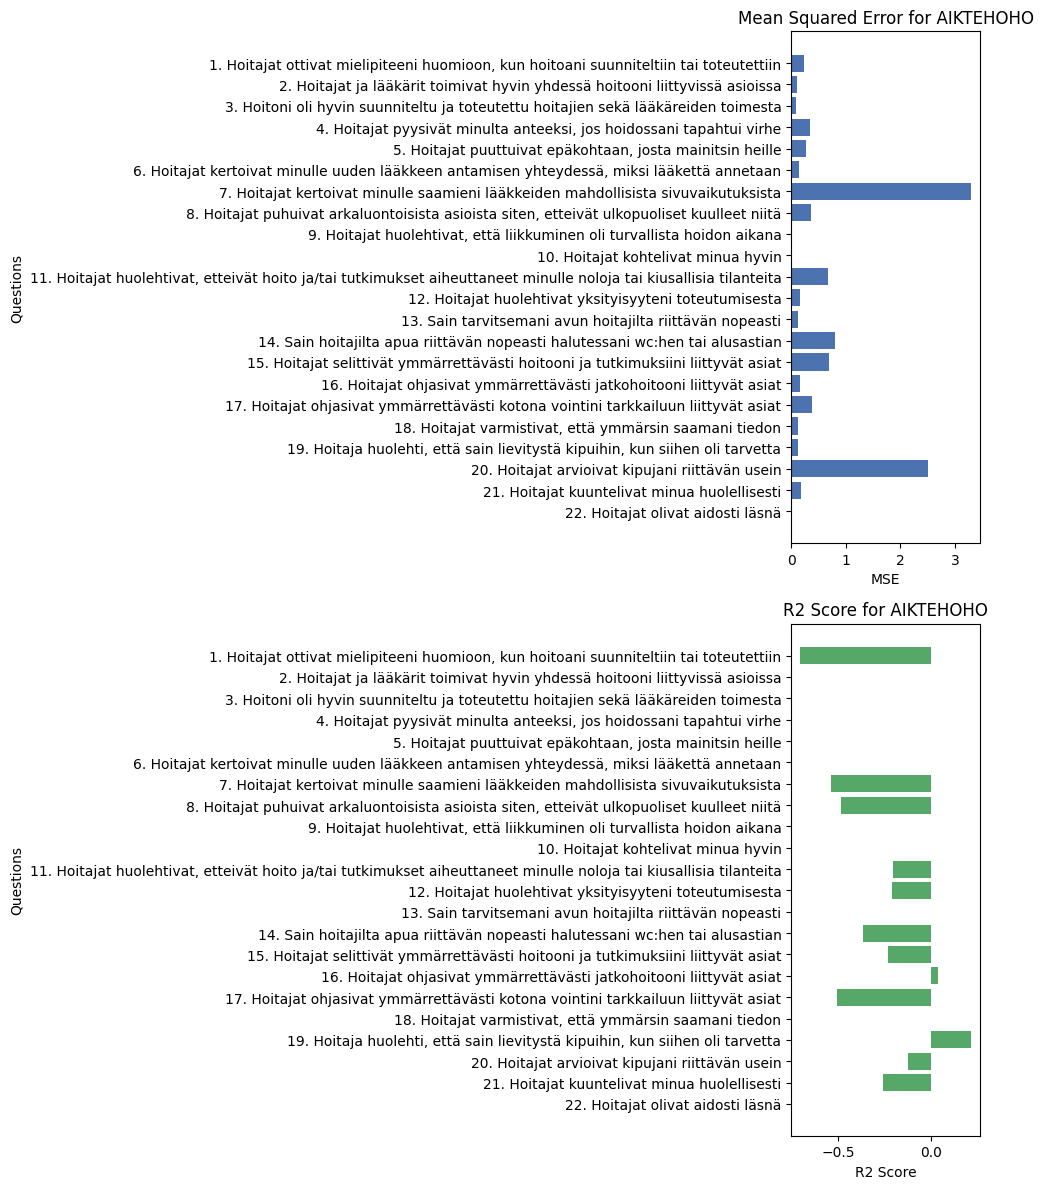

4. Hoitajat pyysivät minulta anteeksi, jos hoidossani tapahtui virhe: Ei tarpeeksi dataa koulutukseen ja testaukseen.
8. Hoitajat puhuivat arkaluontoisista asioista siten, etteivät ulkopuoliset kuulleet niitä: Ei tarpeeksi dataa koulutukseen ja testaukseen.


c:\Users\jonik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\jonik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\jonik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\jonik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\jonik\AppData\Local\Programs\Python\Python3

19. Hoitaja huolehti, että sain lievitystä kipuihin, kun siihen oli tarvetta: Ei tarpeeksi dataa koulutukseen ja testaukseen.
20. Hoitajat arvioivat kipujani riittävän usein: Ei tarpeeksi dataa koulutukseen ja testaukseen.


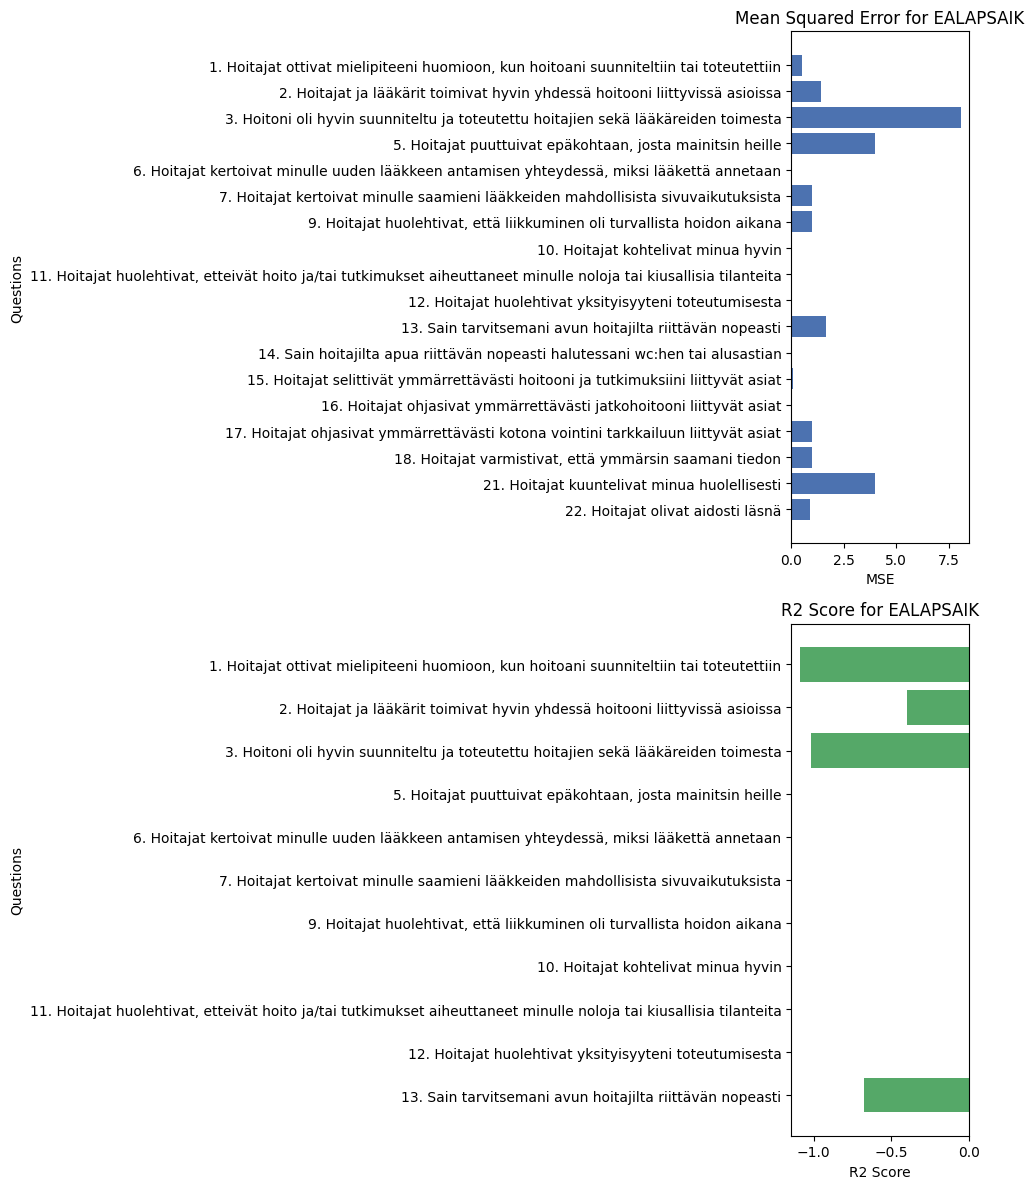

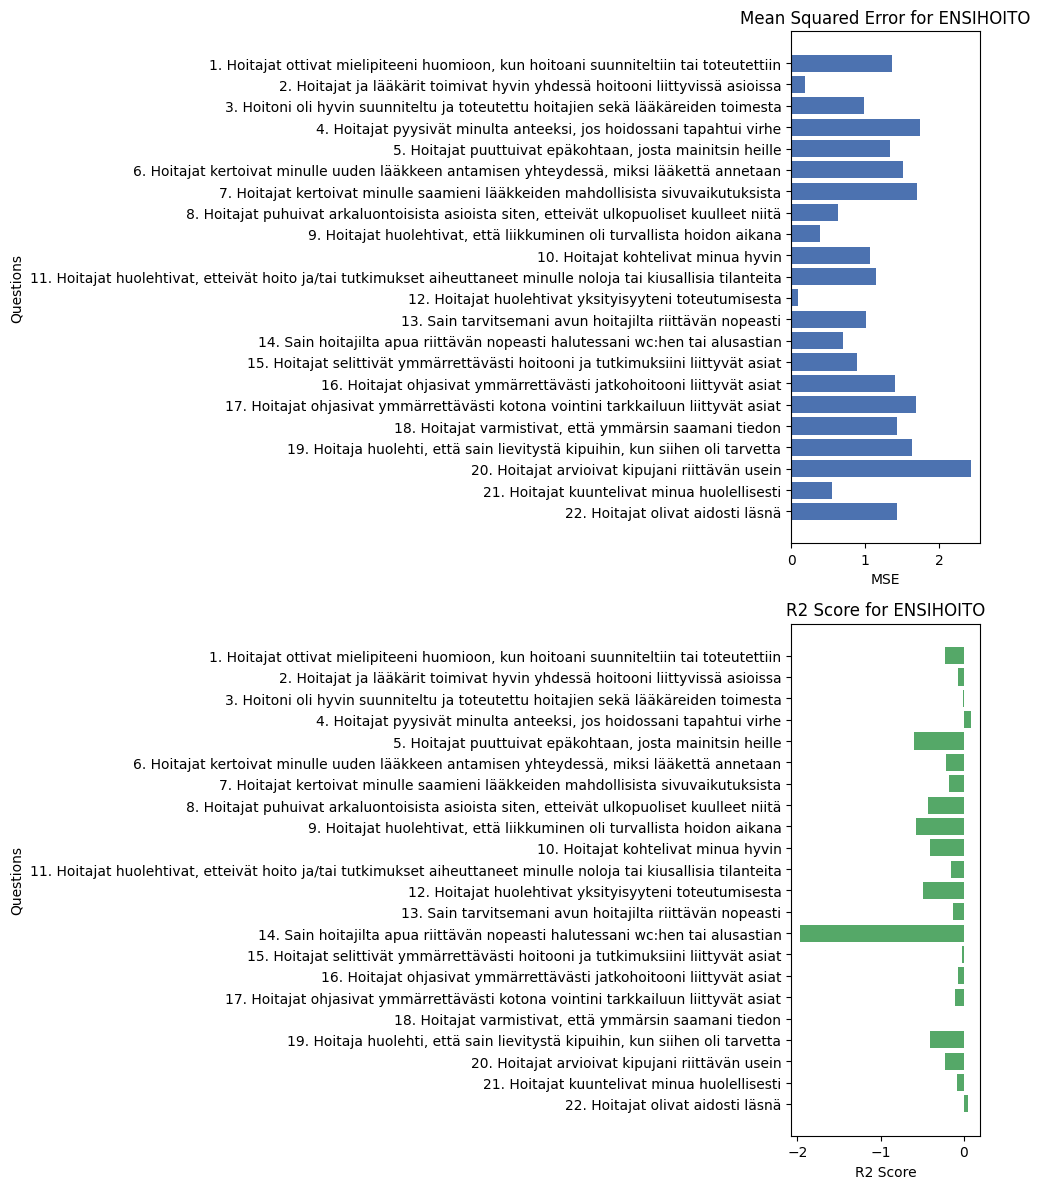

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Funktio ennustaa kullekin yksikölle seuraavan vuosineljänneksen kysymyksen keskiarvot
def ennusta_keskiarvot(data, unit):
    data_unit = data[data['YKSIKKÖKOODI\nKs. Luokitteluohje Yksikkökoodit-välilehdeltä'] == unit]
    questions = numeric_columns

    mse_scores = []  # Tallennetaan MSE-tulokset
    r2_scores = []   # Tallennetaan R2-tulokset
    question_labels = []  # Tallennetaan kysymysten nimet (jotta voidaan käyttää visualisoinnissa)

    for question in questions:
        data_question = data_unit.dropna(subset=[question])

        if len(data_question) < 2:
            print(f"{question}: Ei tarpeeksi dataa koulutukseen ja testaukseen.")
            continue

        # Määritellään X ja y
        X = data_question[['date_float']]  # Aikamuuttuja
        y = data_question[question]  # Kysymys (kohteena oleva muuttuja)

        # Jaetaan data koulutus- ja testijoukkoihin
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Koulutetaan RandomForest-malli
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)

        # Ennustetaan testijoukolle
        y_pred = model.predict(X_test)

        # Lasketaan arviointimittarit
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Tallennetaan tulokset
        mse_scores.append(mse)
        r2_scores.append(r2)
        question_labels.append(question)

    # Visualisointi
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

    # MSE: Pylväsdiagrammi
    ax1.barh(question_labels, mse_scores, color='#4C72B0')
    ax1.set_title(f'Mean Squared Error for {unit}')
    ax1.set_xlabel('MSE')
    ax1.set_ylabel('Questions')
    ax1.invert_yaxis()

    # R2: Pylväsdiagrammi  
    ax2.barh(question_labels, r2_scores, color='#55A868')
    ax2.set_title(f'R2 Score for {unit}')
    ax2.set_xlabel('R2 Score')
    ax2.set_ylabel('Questions')
    ax2.invert_yaxis()

    plt.tight_layout()
    plt.show()

for unit in selected_units:
    ennusta_keskiarvot(data, unit)

In [2]:
for file in file_paths:
    try:
        df = pd.read_excel(file)
        print(f"Ladattu tiedosto: {file}")
    except Exception as e:
        print(f"Virhe tiedoston lataamisessa {file}: {e}")


Ladattu tiedosto: C:/Users/jonik/code/Projekti_2/project_sigma/data/HOPP/117_HOpp-Q2_2023.xlsx
Ladattu tiedosto: C:/Users/jonik/code/Projekti_2/project_sigma/data/HOPP/117_HOpp-Q3_2023.xlsx
Ladattu tiedosto: C:/Users/jonik/code/Projekti_2/project_sigma/data/HOPP/HoPP_Q1_Kaks_Tiedonkeruulomake_kansallinen_2022.xlsx
Ladattu tiedosto: C:/Users/jonik/code/Projekti_2/project_sigma/data/HOPP/HoPP_Q3_KAKS_Tiedonkeruulomake_kansallinen_2022.xlsx
Ladattu tiedosto: C:/Users/jonik/code/Projekti_2/project_sigma/data/HOPP/HoPP_Q4_KAKS_Tiedonkeruulomake_kansallinen_2022.xlsx


In [3]:
print(data.columns)


Index(['ORGANISAATIOKOODI (kolme numeroa)',
       'YKSIKKÖKOODI\nKs. Luokitteluohje Yksikkökoodit-välilehdeltä',
       'KVARTAALI JA VUOSI\n(ESIM. 1_2020)',
       '1. Hoitajat ottivat mielipiteeni huomioon, kun hoitoani suunniteltiin tai toteutettiin',
       '2. Hoitajat ja lääkärit toimivat hyvin yhdessä hoitooni liittyvissä asioissa',
       '3. Hoitoni oli hyvin suunniteltu ja toteutettu hoitajien sekä lääkäreiden toimesta',
       '4. Hoitajat pyysivät minulta anteeksi, jos hoidossani tapahtui virhe',
       '5. Hoitajat puuttuivat epäkohtaan, josta mainitsin heille',
       '6. Hoitajat kertoivat minulle uuden lääkkeen antamisen yhteydessä, miksi lääkettä annetaan',
       '7. Hoitajat kertoivat minulle saamieni lääkkeiden mahdollisista sivuvaikutuksista',
       '8. Hoitajat puhuivat arkaluontoisista asioista siten, etteivät ulkopuoliset kuulleet niitä',
       '9. Hoitajat huolehtivat, että liikkuminen oli turvallista hoidon aikana',
       '10. Hoitajat kohtelivat minua hyv

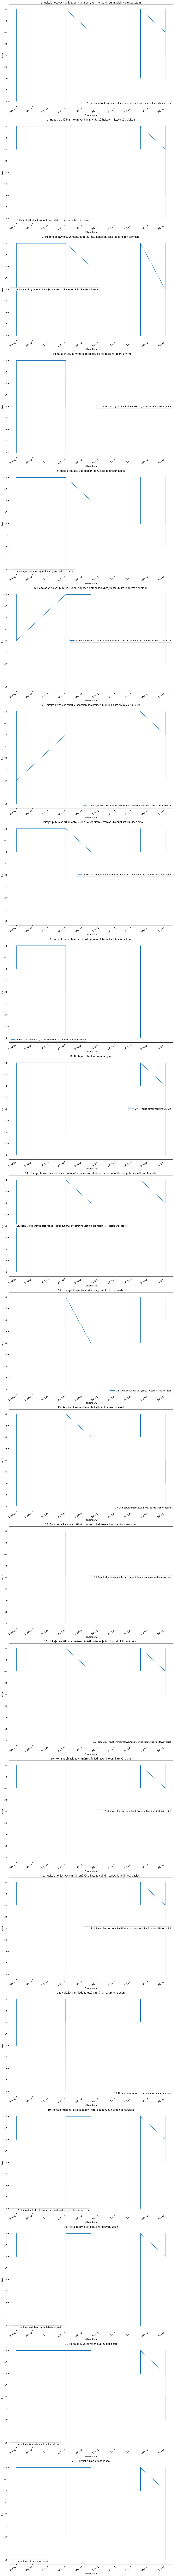

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Oletetaan, että olet jo suorittanut analyysin ja sinulla on data-DataFrame nimeltä 'data'

# Luo visualisointien polku
fig, axes = plt.subplots(len(numeric_columns), 1, figsize=(12, 8*len(numeric_columns)))

# Piirrä yksi visuaalinen esitys per kysymys
for i, question in enumerate(numeric_columns):
    ax = axes[i]
    data.plot(x='date', y=question, ax=ax)
    ax.set_title(question)
    ax.set_xlabel('Päivämäärä')
    ax.set_ylabel('Arvo')

# Näytä visualisoinnit
plt.tight_layout()
plt.show()

In [5]:
print(data.isna().sum())


ORGANISAATIOKOODI (kolme numeroa)                                                                                      0
YKSIKKÖKOODI\nKs. Luokitteluohje Yksikkökoodit-välilehdeltä                                                            0
KVARTAALI JA VUOSI\n(ESIM. 1_2020)                                                                                     0
1. Hoitajat ottivat mielipiteeni huomioon, kun hoitoani suunniteltiin tai toteutettiin                                 8
2. Hoitajat ja lääkärit toimivat hyvin yhdessä hoitooni liittyvissä asioissa                                          22
3. Hoitoni oli hyvin suunniteltu ja toteutettu hoitajien sekä lääkäreiden toimesta                                    18
4. Hoitajat pyysivät minulta anteeksi, jos hoidossani tapahtui virhe                                                  97
5. Hoitajat puuttuivat epäkohtaan, josta mainitsin heille                                                             83
6. Hoitajat kertoivat minulle uu